In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.sparse
from joblib import Parallel, delayed
from enum import Enum

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher

plt.style.use('ggplot')

## Download Data

In [ ]:
def download_dataset():
    urllib.request.urlretrieve(
        "https://s3-eu-west-1.amazonaws.com/attribution-dataset/criteo_attribution_dataset.zip", 
        "criteo_attribution_dataset.zip"
    )
  
    with zipfile.ZipFile("criteo_attribution_dataset.zip", "r") as zip_ref:
        zip_ref.extractall("criteo_attribution_dataset")

In [ ]:
dataset_path = 'criteo_attribution_dataset/criteo_attribution_dataset.tsv.gz'

if not os.path.exists(dataset_path):
    download_dataset()

## Preprocessing

In [ ]:
df = pd.read_csv(dataset_path, sep='\t', compression="gzip")

In [ ]:
# On Google colab, one must use a smaller dataset (with debug_sample=1e-2)
debug_sample = 1.0

uid_and_salt = df['uid'].astype(str) + 'hash_salt_for_sampling'
hashed_uid_and_salt = pd.util.hash_pandas_object(uid_and_salt, index=False)
random_column_based_on_uid = hashed_uid_and_salt / np.iinfo(np.uint64).max
debug_df = df[random_column_based_on_uid < debug_sample]
debug_df

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16468022,2671199,5767906,4869923,0,-1,-1,0,1,-1,-1,...,482560,30763035,26597095,13113052,29196072,5824236,30763035,18391143,29196072,8661623
16468023,2671199,6852682,10002432,0,-1,-1,0,0,-1,-1,...,971748,25259032,9312274,10979162,29196072,32440044,29196072,27259439,29196072,8661620
16468024,2671199,16638720,7061828,0,-1,-1,0,0,-1,-1,...,268431,30763035,5824235,29542751,29196072,5824237,29196072,3696777,29196072,21091111
16468025,2671199,3032300,5061834,0,-1,-1,0,1,-1,-1,...,-1,1973606,26597096,28944164,29196072,26611392,1973606,5642940,14911188,29196072


In [ ]:
def get_conversion_in_time_window(df, time_window=60*60*24):
    conversion_timestamps = df.groupby('uid').agg({'conversion_timestamp': lambda x: sorted(list(set(x)))})
    conversion_timestamps.rename(columns={'conversion_timestamp': 'conversion_timestamps'}, inplace=True)

    def get_next_conversion_timestamp(data):
        next_conversion_index = np.searchsorted(data['conversion_timestamps'], data['timestamp'])
        if next_conversion_index == len(data['conversion_timestamps']):
            return -1
        else:
            return data['conversion_timestamps'][next_conversion_index]

    df_with_ct = df.merge(conversion_timestamps, on='uid', how='outer', validate="many_to_one")

    matched_displays_mask = df_with_ct['conversion_timestamp'] > 0
    df_with_ct['next_conversion_timestamp'] = np.where(
        matched_displays_mask,
        df_with_ct['conversion_timestamp'],
        df_with_ct.apply(get_next_conversion_timestamp, axis=1)
    )
    
    df_with_ct['conversion_in_time_window'] = np.where(
        df_with_ct['next_conversion_timestamp'] != -1,
        ((df_with_ct['next_conversion_timestamp'] - df_with_ct['timestamp']) <= time_window).astype(int),
        0
    )
    
    
    original_column_order = list(df.columns) + ['conversion_in_time_window']
    return df_with_ct[original_column_order]

In [ ]:
debug = True
if debug:
    test_df = pd.DataFrame([
        {'uid': 1, 'timestamp': 1, 'conversion_timestamp': -1},
        {'uid': 1, 'timestamp': 2, 'conversion_timestamp': -1},
        {'uid': 1, 'timestamp': 3, 'conversion_timestamp': 6},
        {'uid': 1, 'timestamp': 4, 'conversion_timestamp': 6},
        {'uid': 1, 'timestamp': 7, 'conversion_timestamp': -1},
        {'uid': 1, 'timestamp': 8, 'conversion_timestamp': 10},
        {'uid': 1, 'timestamp': 9, 'conversion_timestamp': 10},
        {'uid': 1, 'timestamp': 11, 'conversion_timestamp': -1},
        {'uid': 1, 'timestamp': 12, 'conversion_timestamp': -1},
        {'uid': 2, 'timestamp': 1, 'conversion_timestamp': -1},
        {'uid': 2, 'timestamp': 2, 'conversion_timestamp': -1},
        # Edge case : sometimes (rarely, the conversion is not mapped to the next one)
        {'uid': 3, 'timestamp': 1, 'conversion_timestamp': -1},
        {'uid': 3, 'timestamp': 2, 'conversion_timestamp': 7},
        {'uid': 3, 'timestamp': 3, 'conversion_timestamp': 4},
        {'uid': 3, 'timestamp': 5, 'conversion_timestamp': 7},
        {'uid': 3, 'timestamp': 6, 'conversion_timestamp': 7},
    ])
    split_test_df = pd.DataFrame([
        {'uid': 1, 'timestamp': 1, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        {'uid': 1, 'timestamp': 2, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        {'uid': 1, 'timestamp': 3, 'conversion_timestamp': 6, 'conversion_in_time_window': 0},
        {'uid': 1, 'timestamp': 4, 'conversion_timestamp': 6, 'conversion_in_time_window': 1},
        {'uid': 1, 'timestamp': 7, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        {'uid': 1, 'timestamp': 8, 'conversion_timestamp': 10, 'conversion_in_time_window': 1},
        {'uid': 1, 'timestamp': 9, 'conversion_timestamp': 10, 'conversion_in_time_window': 1},
        {'uid': 1, 'timestamp': 11, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        {'uid': 1, 'timestamp': 12, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        {'uid': 2, 'timestamp': 1, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        {'uid': 2, 'timestamp': 2, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        # Edge case
        {'uid': 3, 'timestamp': 1, 'conversion_timestamp': -1, 'conversion_in_time_window': 0},
        {'uid': 3, 'timestamp': 2, 'conversion_timestamp': 7, 'conversion_in_time_window': 0},
        {'uid': 3, 'timestamp': 3, 'conversion_timestamp': 4, 'conversion_in_time_window': 1},
        {'uid': 3, 'timestamp': 5, 'conversion_timestamp': 7, 'conversion_in_time_window': 1},
        {'uid': 3, 'timestamp': 6, 'conversion_timestamp': 7, 'conversion_in_time_window': 1},
    ])

    assert split_test_df.equals(get_conversion_in_time_window(test_df, time_window=2))

In [ ]:
def get_nb_clicks(df, time_window=60*60*24):
    click_timestamps = df[df['click'] == 1].groupby('uid').agg({'timestamp': lambda x: sorted(list(set(x)))})
    click_timestamps.rename(columns={'timestamp': 'click_timestamps'}, inplace=True)

    def get_nb_clicks(data):
        if isinstance(data['click_timestamps'], list) and len(data['click_timestamps']) > 0:
            return np.searchsorted(data['click_timestamps'], data['timestamp'])
        else:
            return 0

    df_with_ct = df.merge(click_timestamps, on='uid', how='outer', validate="many_to_one")
    df_with_ct['nb_clicks'] = df_with_ct.apply(get_nb_clicks, axis=1)
    
    original_column_order = list(df.columns) + ['nb_clicks']
    return df_with_ct[original_column_order]

In [ ]:
debug = True
if debug:
    test_df = pd.DataFrame([
        {'uid': 1, 'timestamp': 1, 'click': 0},
        {'uid': 1, 'timestamp': 2, 'click': 0},
        {'uid': 1, 'timestamp': 3, 'click': 1},
        {'uid': 1, 'timestamp': 4, 'click': 1},
        {'uid': 1, 'timestamp': 7, 'click': 0},
        {'uid': 1, 'timestamp': 8, 'click': 1},
        {'uid': 1, 'timestamp': 9, 'click': 1},
        {'uid': 1, 'timestamp': 11, 'click': 0},
        {'uid': 1, 'timestamp': 12, 'click': 0},
        {'uid': 2, 'timestamp': 1, 'click': 0},
        {'uid': 2, 'timestamp': 2, 'click': 0},
    ])
    nb_clicks_test_df = pd.DataFrame([
        {'uid': 1, 'timestamp': 1, 'click': 0, "nb_clicks": 0},
        {'uid': 1, 'timestamp': 2, 'click': 0, "nb_clicks": 0},
        {'uid': 1, 'timestamp': 3, 'click': 1, "nb_clicks": 0},
        {'uid': 1, 'timestamp': 4, 'click': 1, "nb_clicks": 1},
        {'uid': 1, 'timestamp': 7, 'click': 0, "nb_clicks": 2},
        {'uid': 1, 'timestamp': 8, 'click': 1, "nb_clicks": 2},
        {'uid': 1, 'timestamp': 9, 'click': 1, "nb_clicks": 3},
        {'uid': 1, 'timestamp': 11, 'click': 0, "nb_clicks": 4},
        {'uid': 1, 'timestamp': 12, 'click': 0, "nb_clicks": 4},
        {'uid': 2, 'timestamp': 1, 'click': 0, "nb_clicks": 0},
        {'uid': 2, 'timestamp': 2, 'click': 0, "nb_clicks": 0},
    ])

    assert nb_clicks_test_df.equals(get_nb_clicks(test_df))

In [ ]:
def preprocess_dataframe(input_df, refresh=False):
    df_identifier = '_'.join(map(str, input_df.shape))
    cache_directory = 'cache_ifa_lr'
    cache_path = os.path.join(cache_directory, df_identifier, 'preprocess.pkl')
    if os.path.exists(cache_path) and not refresh:
        print('Load from', cache_path)
        df = pd.read_pickle(cache_path)

    else:
        df = input_df.copy()
        df['uid'] = df['uid'].astype(str) + '_' + df['campaign'].astype(str)
        
        df['day'] = np.floor(df['timestamp'] / 86400.).astype(int)
        
        loground_bucketize = True
        if loground_bucketize:
            df['time_since_last_click_bucketized'] = np.where(
                df['time_since_last_click'] > 0,
                np.log(1 + df['time_since_last_click'] / 60).astype(int),
                df['time_since_last_click'],
            )
        else:
            packed_hours = 4
            df['time_since_last_click_bucketized'] = (df['time_since_last_click'] / (packed_hours * 3600)).astype(int).values
            df['time_since_last_click_bucketized'] *= packed_hours

        df['gap_click_sale'] = -1
        df.loc[df['conversion'] == 1, 'gap_click_sale'] = df['conversion_timestamp'] - df['timestamp']

        df['last_click'] = df['attribution'] * (df['click_pos'] == df['click_nb'] - 1).astype(int)
        df = get_conversion_in_time_window(df)
        df = get_nb_clicks(df)
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        df.to_pickle(cache_path)

    return df

In [ ]:
%%time

enriched_df = preprocess_dataframe(debug_df, refresh=False)
with pd.option_context('display.max_columns', 1000):
    display(enriched_df.head())

Load from cache_ifa_lr/16468027_22/preprocess.pkl


,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,day,time_since_last_click_bucketized,gap_click_sale,last_click,conversion_in_time_window,nb_clicks
0,0,20073966_22589171,22589171,0,-1,-1,0,0,-1,-1,0.000010,0.390794,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072,0,-1,-1,0,0,0
1,2,24607497_884761,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111,0,8,-1,0,0,0
2,227,24607497_884761,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,424083,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111,0,8,-1,0,0,0
3,422169,24607497_884761,884761,0,-1,-1,0,1,-1,-1,0.000049,0.061053,846025,30763035,9312274,14584482,29196072,11409686,1973606,27926977,26597096,8661620,4,9,-1,0,0,0
4,590673,24607497_884761,884761,0,-1,-1,0,0,-1,-1,0.000010,0.060939,168504,30763035,9312274,14584482,29196072,11409686,1973606,27926977,9312274,21091108,6,7,-1,0,0,1


CPU times: user 2.23 s, sys: 3.14 s, total: 5.36 s
Wall time: 7.04 s


In [ ]:
FEATURES = ['campaign', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'time_since_last_click_bucketized', 'nb_clicks']
INFOS = ['cost', 'cpo', 'time_since_last_click']
INFOS += ['last_click', 'first_click', 'uniform']

## Learning

### Last click model

In [ ]:
class SplitBy(Enum):
    UID = 1
    DATE = 2

def split_train_test_mask(split_by, df, ratio):
    """We split the dataset into train and test parts. 
    We can either split it by day (learn on the past to predict the future)
    or by uid (learn on a part of the population and test on the other part)
    """
    if split_by == SplitBy.UID:
        uid_and_salt = df['uid'].astype(str) + 'hash_salt_for_train_test_split'
        hashed_uid_and_salt = pd.util.hash_pandas_object(uid_and_salt, index=False)
        random_column_based_on_uid = hashed_uid_and_salt / np.iinfo(np.uint64).max

        is_training = random_column_based_on_uid < ratio

    if split_by == SplitBy.DATE:
        split_day = max(1, ratio * df['day'].max())
        is_training = df['day'] < split_day

    return is_training

In [ ]:
%%time

cache_directory = 'cache_ifa_lr'
features_file = 'features.npz'

def features_to_list_of_strings(row):
    return [f'{feature}_{row[feature]}' for feature in row.index]

def get_features(df, features_columns, hash_space=2**13):
    df_identifier = '_'.join(map(str, enriched_df.shape))
    label_features_identifier = f'{"_".join(features_columns)}'
    cache_path = os.path.join(cache_directory, df_identifier, label_features_identifier, str(hash_space))

    features_cache_path = os.path.join(cache_path, features_file)
    print('features_cache_path',features_cache_path)

    if os.path.exists(features_cache_path):
        features = scipy.sparse.load_npz(features_cache_path)

    else:
        raw_features = df[features_columns]

        features_as_list_of_strings = raw_features.apply(features_to_list_of_strings, axis=1)
        hasher = FeatureHasher(n_features=hash_space, input_type='string', alternate_sign=False)
        features = hasher.fit_transform(features_as_list_of_strings)
        os.makedirs(cache_path)
        scipy.sparse.save_npz(features_cache_path, features)

    return features

features = get_features(enriched_df, FEATURES, hash_space=2**16)
is_training = split_train_test_mask(SplitBy.UID, enriched_df, 0.8)

features_cache_path cache_ifa_lr/16468027_28/campaign_cat1_cat2_cat3_cat4_cat5_cat6_cat7_cat8_cat9_time_since_last_click_bucketized_nb_clicks/65536/features.npz
CPU times: user 18.3 s, sys: 1.77 s, total: 20 s
Wall time: 20.2 s


In [ ]:
class LastClickModel():
    def __init__(self):
        self.last_click_model = LogisticRegression(max_iter=1000)
    
    def fit(self, enriched_df, features):
        is_clicked = enriched_df['click'] == 1
        last_click_labels = enriched_df['last_click']
        last_click_given_click_labels = last_click_labels[is_clicked]
        features_given_click = features[is_clicked]

        self.last_click_model = LogisticRegression(max_iter=1000)
        self.last_click_model.fit(features_given_click, last_click_given_click_labels)
        
    def predict_proba(self, features):
        return self.last_click_model.predict_proba(features)[:, 1]

In [ ]:
%%time 

last_click_model = LastClickModel()
last_click_model.fit(enriched_df[is_training], features[is_training])

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 43min 36s, sys: 56min 37s, total: 1h 40min 14s
Wall time: 10min 23s


### Incrementality factor model

In [ ]:
class IFAModel():
    def __init__(self):
        self.sales_given_click_model = LogisticRegression(max_iter=1000)
        self.sales_given_no_click_model = LogisticRegression(max_iter=1000)
    
    def fit(self, enriched_df, features):
        is_clicked = enriched_df['click'] == 1
        sales_labels = enriched_df['conversion_in_time_window']
        labels_given_click, features_given_click = sales_labels[is_clicked], features[is_clicked]
        labels_given_no_click, features_given_no_click = sales_labels[~is_clicked], features[~is_clicked]
        
        self.sales_given_click_model.fit(features_given_click, labels_given_click)
        self.sales_given_no_click_model.fit(features_given_no_click, labels_given_no_click)
        
    def predict_ifa(self, features, epsilon=1e-2):
        p_sales_given_click = self.sales_given_click_model.predict_proba(features)[:, 1]
        p_sales_given_no_click = self.sales_given_no_click_model.predict_proba(features)[:, 1]
        ifa = 1 - p_sales_given_no_click / p_sales_given_click    
        return np.maximum(np.minimum(ifa, 1 - epsilon), epsilon)
        
    def predict_proba(self, features, epsilon=1e-2):
        p_sales_given_click = self.sales_given_click_model.predict_proba(features)[:, 1]
        return self.predict_ifa(features, epsilon=epsilon) * p_sales_given_click

In [ ]:
%%time 

ifa_model = IFAModel()
ifa_model.fit(enriched_df[is_training], features[is_training])

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1h 11min 18s, sys: 1h 27min 51s, total: 2h 39min 9s
Wall time: 20min 26s


In [ ]:
packed_hours = 6
hour_since_last_click = (enriched_df['time_since_last_click'][is_training] / (packed_hours * 3600)).astype(int).values
hour_since_last_click *= packed_hours

temp_df = pd.DataFrame()
temp_df['ifa'] = ifa_model.predict_ifa(features[is_training])
temp_df['hour_since_last_click'] = hour_since_last_click
temp_df = temp_df[temp_df['hour_since_last_click'] > 0]

tslc_mean_scores_df = temp_df.groupby('hour_since_last_click').mean()

In [ ]:
temp_df = pd.DataFrame()
temp_df['ifa'] = ifa_model.predict_ifa(features[is_training])
temp_df['nb_clicks'] = enriched_df['nb_clicks']

nb_clicks_mean_scores_df = temp_df.groupby('nb_clicks').mean()

In [ ]:
cache_ifa_results_dir = 'cache_ifa_results_dir'
os.makedirs(cache_ifa_results_dir, exist_ok=True)

tslc_mean_scores_file_path = os.path.join(cache_ifa_results_dir, f"tslc_mean_scores_file_{debug_sample}.csv")
nb_clicks_mean_scores_file_path = os.path.join(cache_ifa_results_dir, f"nb_clicks_mean_scores_file_{debug_sample}.csv")


In [ ]:
tslc_mean_scores_df.to_csv(tslc_mean_scores_file_path)
nb_clicks_test_df.to_csv(nb_clicks_mean_scores_file_path)

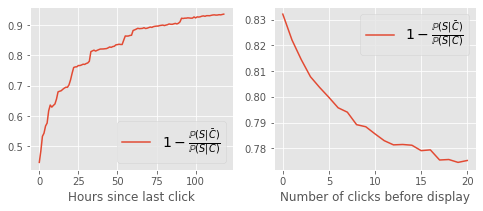

In [ ]:
tslc_mean_scores_df = pd.read_csv(tslc_mean_scores_file_path)
nb_clicks_test_df = pd.read_csv(nb_clicks_mean_scores_file_path)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ifa_label = r'$1 - \frac{\mathbb{P}(S|\bar{C})}{\mathbb{P}(S|C)}$'

ax_tslc = axes[0]
n_hours = 24000
keep_x_tslc = int(n_hours / packed_hours)
ax_tslc.plot(tslc_mean_scores_df.index[:keep_x_tslc], tslc_mean_scores_df['ifa'][:keep_x_tslc], label=ifa_label)
ax_tslc.set_xlabel('Hours since last click')
ax_tslc.legend(fontsize=14)

lbda_pcb = 6.25e-6
x_in_seconds = tslc_mean_scores_df.index[:keep_x_tslc].values * 3600
pcb_factor = 1 - np.exp(- lbda_pcb * x_in_seconds)
#ax_tslc.plot(tslc_mean_scores_df.index[:keep_x_tslc],pcb_factor)

ax_nclicks = axes[1]
keep_x_nclicks = 21
ax_nclicks.plot(nb_clicks_mean_scores_df.index[:keep_x_nclicks], nb_clicks_mean_scores_df['ifa'][:keep_x_nclicks], label=ifa_label)
ax_nclicks.set_xlabel('Number of clicks before display')

ax_nclicks.legend(fontsize=14)
plt.savefig('ifa_value_sanity_checks.pdf', bbox_inches='tight')

In [ ]:
%%time

click_model = LogisticRegression(max_iter=1000)
click_model.fit(features[is_training], enriched_df['click'][is_training])

CPU times: user 53min 13s, sys: 49min 42s, total: 1h 42min 56s
Wall time: 27min 43s


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=1000)

In [ ]:
def log_likelihood(label, predictor):
    return label * np.log(predictor) + (1 - label) * np.log(1 - predictor)

def revert_the_label_likelihood(click_model_or_p_click, enriched_df, features, evaluated_model):
    click_labels = enriched_df['click']
    sales_labels = enriched_df['conversion_in_time_window']
    
    if hasattr(click_model_or_p_click, 'predict_proba'):
        p_C = click_model_or_p_click.predict_proba(features)[:, 1]
    else:
        p_C = click_model_or_p_click
    
    y_predictor = evaluated_model.predict_proba(features)
     
    weighted_llh_c_sales = click_labels / p_C * (log_likelihood(sales_labels, y_predictor))
    penalized_unclicked_sales = (1 - click_labels) * sales_labels / (1 - p_C) * (np.log((1 - y_predictor) / y_predictor))
     
    return np.mean(weighted_llh_c_sales + penalized_unclicked_sales)

In [ ]:
cache_ifa_results_dir = 'cache_ifa_results_dir'
os.makedirs(cache_ifa_results_dir, exist_ok=True)

llh_results_file_path = os.path.join(cache_ifa_results_dir, f"llh_results_file_{debug_sample}.csv")

In [ ]:
%%time

def compute_likelihoods(train_pclick, test_pclick, hash_space):
    features = get_features(enriched_df, FEATURES, hash_space=hash_space)
    is_training = split_train_test_mask(SplitBy.UID, enriched_df, 0.8)
    
    train_features, train_enriched_df = features[is_training], enriched_df[is_training]
    test_features, test_enriched_df = features[~is_training], enriched_df[~is_training]
    
    last_click_model = LastClickModel()
    last_click_model.fit(train_enriched_df, train_features)
    
    ifa_model = IFAModel()
    ifa_model.fit(train_enriched_df, train_features)
    
    return (
        revert_the_label_likelihood(train_pclick, train_enriched_df, train_features, ifa_model),
        revert_the_label_likelihood(test_pclick, test_enriched_df, test_features, ifa_model),
        revert_the_label_likelihood(train_pclick, train_enriched_df, train_features, last_click_model),
        revert_the_label_likelihood(test_pclick, test_enriched_df, test_features, last_click_model),
    )

hash_spaces = [2**space for space in range(10, 17)] #10
n_jobs = min(10, len(hash_spaces))

train_pclick = click_model.predict_proba(features[is_training])[:, 1]
test_pclick = click_model.predict_proba(features[~is_training])[:, 1]

#parallel_result = []
#for hash_space in hash_spaces:
#    parallel_result += [compute_likelihoods(train_pclick, test_pclick, hash_space)]

parallel_result = Parallel(n_jobs=n_jobs)(
    delayed(compute_likelihoods)(train_pclick, test_pclick, hash_space) for hash_space in hash_spaces)

ifa_train_llh, ifa_test_llh, lc_train_llh, lc_test_llh = zip(*parallel_result)

llh_df = pd.DataFrame({'hash_spaces': hash_spaces, 'ifa_train_llh': ifa_train_llh, 'ifa_test_llh': ifa_test_llh, 'lc_train_llh': lc_train_llh, 'lc_test_llh': lc_test_llh})
llh_df.to_csv(llh_results_file_path)

CPU times: user 46.1 s, sys: 12.3 s, total: 58.4 s
Wall time: 35min 50s


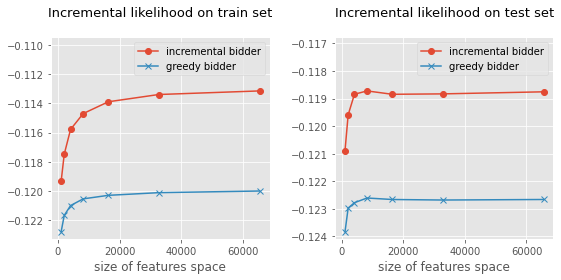

In [ ]:
llh_df = pd.read_csv(llh_results_file_path)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

axes[0].plot(llh_df['hash_spaces'], llh_df['ifa_train_llh'], label='incremental bidder', marker='o')
axes[0].plot(llh_df['hash_spaces'], llh_df['lc_train_llh'], label='greedy bidder', marker='x')

axes[0].set_title('Incremental likelihood on train set\n', fontsize=13)
axes[0].set_xlabel('size of features space')
axes[0].set_ylim([None, axes[0].get_ylim()[1] + (axes[0].get_ylim()[1] - axes[0].get_ylim()[0]) * 0.3])
axes[0].legend()

axes[1].plot(llh_df['hash_spaces'], llh_df['ifa_test_llh'], label='incremental bidder', marker='o')
axes[1].plot(llh_df['hash_spaces'], llh_df['lc_test_llh'], label='greedy bidder', marker='x')

axes[1].set_title('Incremental likelihood on test set\n', fontsize=13)
axes[1].set_xlabel('size of features space')
axes[1].legend()
axes[1].set_ylim([None, axes[1].get_ylim()[1] + (axes[1].get_ylim()[1] - axes[1].get_ylim()[0]) * 0.3])

fig.tight_layout()
plt.savefig('incremental_metrics.pdf')